#  Here, I calculate one hour prediction by Ensemble Kalman Filter 

### Install weather data to predict

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

#インプットデータ
input_data = pd.read_csv('hakata_ekimae_2017_data_from_meteoblue.csv')
#temp = temp.drop("気温(℃).1",axis=1)
#temp = temp.drop("気温(℃).2" ,axis=1)

#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)', 'Mean Sea Level Pressure[hpa]', \
                      'Shortwave Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
              , 'Wind Direction(80m)']

#日付型などの変更
input_data['Date'] = input_data[['Year', 'Month', 'Day']].apply(lambda x: '{}@{}@{}'.format(x[0], x[1], x[2]), axis=1)
Date = input_data['Date']
input_data['Date'] =pd.to_datetime(Date, format='%Y@%m@%d')

input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

#number日分を抽出
number=3
Span = int(24*number+1)
#Span = 1
ThreeDays = input_data[:Span]
Date = input_data.loc[:,['Time']][:Span+1]
ThreeDays = ThreeDays.loc[:,['Wind Speed(10m)[m/s]', 'Temperature(2m)', 'Wind Speed(80m)[m/s]']]

#時間　気温　日射量をarray型でそれぞれ格納
Wind10 = ThreeDays['Wind Speed(10m)[m/s]'][:Span].values
Temperature = ThreeDays['Temperature(2m)'][:Span].values
Wind80 = ThreeDays['Wind Speed(80m)[m/s]'][:Span].values

Time = Date['Time']


print(ThreeDays)

print(Date)

Populating the interactive namespace from numpy and matplotlib
    Wind Speed(10m)[m/s]  Temperature(2m)  Wind Speed(80m)[m/s]
0                   1.66             3.38                  0.92
1                   1.78             3.39                  1.00
2                   1.57             3.45                  1.03
3                   1.80             2.98                  0.70
4                   1.88             2.49                  1.26
5                   2.18             2.25                  1.34
6                   2.31             1.89                  1.92
7                   2.46             1.65                  2.64
8                   2.56             1.75                  2.66
9                   2.42             2.12                  2.48
10                  1.97             3.23                  2.33
11                  1.57             4.29                  2.42
12                  1.10             4.59                  1.40
13                  0.36             5.41

In [2]:
def row(x):    #行
    return x.reshape(1,-1)

def column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]

def myoutput(x):   #xには、列ベクトルを入れること
    #rand = np.random.normal(0, 1, (3, 1))
    #dt=0.01
    #x=x + dt*rand
    return column(x)

#時間　気温　日射量をarray型を2D_行ベクトルに変換
x = row(Wind10)
y = row(Temperature)
z = row(Wind80)

### 作成した時間　気温　日射量をarray型を2D_行ベクトルを縦に並べ、以下のような状態ベクトル $ xtr $ を作成する。

### Array type 2D_ row vectors storing created time, temperature and solar radiation are arranged vertically, and the following state vector xtr is created.

$$
    xtr = \left(
        \begin{array}{cccc}
          Hour(0) & Hour(1) & \ldots & Hour(n) \\
          Temperature(0) & Temperature(1) & \ldots & Temperature(n) \\
          Wind Speed(0) & Wind Speed(1) & \ldots & Wind Speed(80m)[m/s](n)
        \end{array}
      \right)
$$

In [3]:
xtr = np.concatenate([x, y, z], axis=0) #行を縦に並べる
ytr =xtr
yt = ytr
len_t = xtr.shape[1]
print(len_t)

73


### Behavior changes considerably by changing R and Q, so it is necessary to consider.

In [4]:
#分散の初期設定
Rtr = 0.3
###R,Qを変えることで挙動がだいぶ変わってくる
R = np.diag([1, 1, 1]) #3D
Q = np.diag([1, 5, 5])  #3D
#R = np.diag([5, 2, 1]) #3D
#Q = np.diag([2, 4, 3])  #3D

dt = 1
#dt = 0.01

#  EnKFの初期設定
### Mを増やすと安定感が増す。
M = 100   #サンプルの数
barx0 = column(xtr[:,0]) #2D_列ベクトルの状態初期値
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=column(barx0) #2D_列
# アンサンブル行列Y_0/tの作成
y0 = x0 
for i in range(M-1):
        x0_i= barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=1) #3D_列
        y0_i= myoutput( column(x0[:,0])) + np.dot(R,np.random.normal(0, 1, (3, 1))) 
        y0 = np.concatenate([y0,y0_i],axis=1) #3D_列


In [5]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

Vzero = np.array([[0],[0],[0]])
yest=column(ytr[:,0])
yest0 = column(xtr[:,0])
yest0 = column(ytr[:,0])

for i in range(len_t):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列   
    Pxy = np.dot( (np.kron(np.eye(1,M),xhat) - x0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,M),yhat) - y0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j = column( x0[:,j] + np.dot(K, (yt[:,i] - y0[:,j]) ) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(np.dot(Q, np.random.normal(0, 1, (3, 1))) * dt ) #array型
        
        
        y0[:,j] = column2array(  myoutput(column(x0[:,j])) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型
     

In [6]:
#yest=np.delete(yest, 0, 1)
#yest = np.concatenate([yest0,yest],axis=1) #3D_列
xtr = np.concatenate([xtr,Vzero],axis=1)
ytr = np.concatenate([ytr,Vzero],axis=1)
print(yest.shape)
print(ytr.shape)
print(xtr.shape)
yest

(3, 74)
(3, 74)
(3, 74)


array([[ 1.66      ,  1.51232656,  1.74011442,  1.65154837,  1.78162856,
         1.54378492,  1.80175078,  1.98672839,  2.29768144,  2.27475008,
         2.66403674,  2.3012784 ,  1.85130331,  1.67968733,  1.20857834,
         0.33986185,  0.59903778,  0.13232275,  0.64841838,  1.1536928 ,
         1.44705837,  1.63589252,  1.76369793,  1.43733334,  1.47990717,
         1.28582011,  1.22158028,  1.01086633,  1.00749087,  1.0160376 ,
         2.07126234,  1.71252781,  1.64524458,  1.85901629,  2.15395824,
         2.50108116,  4.4821332 ,  5.14739613,  4.69200348,  4.80235131,
         5.06958101,  4.59527837,  5.32638364,  4.42762752,  3.83842328,
         4.31001755,  3.25797801,  0.98318535,  1.48309148,  1.35105175,
         0.69723374,  0.43279538,  0.65561064,  0.76388708,  0.57981861,
         0.75838047,  1.07379277,  1.25232858,  1.14015831,  1.17112112,
         0.57584059,  0.49273509,  0.61780673,  0.82364048,  0.63617697,
         0.74558043,  0.868053  ,  1.48356595,  2.0

In [7]:
ThreeDays

,Wind Speed(10m)[m/s],Temperature(2m),Wind Speed(80m)[m/s]
0,1.66,3.38,0.92
1,1.78,3.39,1.00
2,1.57,3.45,1.03
3,1.80,2.98,0.70
4,1.88,2.49,1.26
5,2.18,2.25,1.34
6,2.31,1.89,1.92
7,2.46,1.65,2.64
8,2.56,1.75,2.66
9,2.42,2.12,2.48


In [8]:
df = pd.DataFrame({ 'Time' : Time,
                    'xtr1_Wind10' : xtr[0,:],
                    'xtr2_Temp' : xtr[1,:],
                    'xtr3_Wind80' : xtr[2,:],
                    'ytr1_Wind10' : ytr[0,:],
                    'ytr2_Temp' : ytr[1,:],
                    'ytr3_Wind80' : ytr[2,:],
                    'yest1_Wind10' : yest[0,:],
                    'yest2_Temp' : yest[1,:],
                    'yest3_Wind80' : yest[2,:],
                  })

#df1 = df.set_index(['Time'])

df[:24]

#df = df[24*70:24*77]

,Time,xtr1_Wind10,xtr2_Temp,xtr3_Wind80,yest1_Wind10,yest2_Temp,yest3_Wind80,ytr1_Wind10,ytr2_Temp,ytr3_Wind80
0,2017-01-01 00:00:00,1.66,3.38,0.92,1.660000,3.380000,0.920000,1.66,3.38,0.92
1,2017-01-01 01:00:00,1.78,3.39,1.00,1.512327,3.355038,0.989111,1.78,3.39,1.00
2,2017-01-01 02:00:00,1.57,3.45,1.03,1.740114,2.920261,0.282443,1.57,3.45,1.03
3,2017-01-01 03:00:00,1.80,2.98,0.70,1.651548,2.641082,1.389719,1.80,2.98,0.70
4,2017-01-01 04:00:00,1.88,2.49,1.26,1.781629,3.599865,1.037323,1.88,2.49,1.26
5,2017-01-01 05:00:00,2.18,2.25,1.34,1.543785,2.424295,0.138313,2.18,2.25,1.34
6,2017-01-01 06:00:00,2.31,1.89,1.92,1.801751,1.894293,1.836085,2.31,1.89,1.92
7,2017-01-01 07:00:00,2.46,1.65,2.64,1.986728,2.154548,0.997412,2.46,1.65,2.64
8,2017-01-01 08:00:00,2.56,1.75,2.66,2.297681,2.204516,1.685819,2.56,1.75,2.66
9,2017-01-01 09:00:00,2.42,2.12,2.48,2.274750,1.390488,3.280810,2.42,2.12,2.48


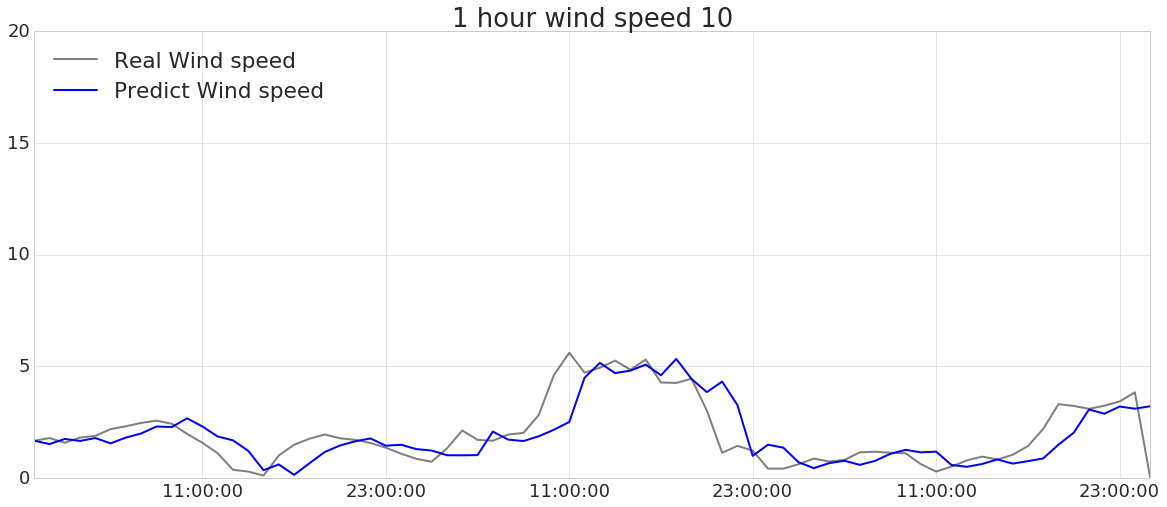

In [9]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18

input1 = df['Time']
output1 = df['xtr1_Wind10']
output2 = df['yest1_Wind10']

fig = plt.figure() 
ax = plt.axes() 

ylim = [0, 20]
ax.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Wind speed") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Wind speed") #同じfigureの中に追加

plt.title("1 hour wind speed 10")
plt.legend(loc="upper left")
#plt.savefig("graph_modifcation.png")

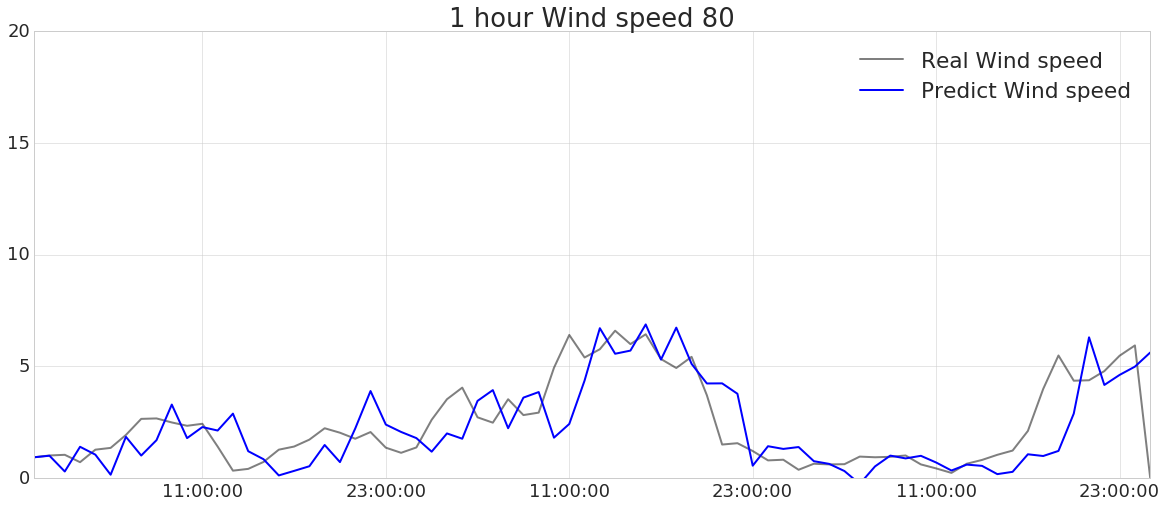

In [10]:
input1 = df['Time']
output1 = df['xtr3_Wind80']
output2 = df['yest3_Wind80']

fig1 = plt.figure() 
ax1 = plt.axes() 

ylim = [0, 20]
ax1.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Wind speed") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Wind speed") #同じfigureの中に追加

plt.title("1 hour Wind speed 80")
plt.legend(loc="upper right")
#plt.savefig("graph_modifcation.png")